# Time Series Aggregation (2022-2025)

This notebook creates monthly aggregated time series data by combining:
1. Historic data (2022-2024) from notebook 07
2. June 2025 data from notebook 04

## Objectives
1. Load consolidated historic data (36 months)
2. Load June 2025 processed data
3. Create monthly aggregations by Betriebszentralen
4. Merge into complete time series (42 months total)
5. Prepare data for forecasting models

## Output
- **Time range**: January 2022 - December 2024 (36 months)
- **Granularity**: Monthly aggregations by Betriebszentralen (14 dispatch centers)
- **Metrics**: Orders, KM, carriers, costs, efficiency

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Section 1: Load Historic Data (2022-2024)

Load the consolidated historic dataset created in notebook 07.

In [2]:
# Load historic data (use Parquet for faster loading)
historic_path = Path('../data/processed/historic_orders_2022_2024.parquet')

if historic_path.exists():
    print(f"Loading historic data from {historic_path}...")
    df_historic = pd.read_parquet(historic_path)
    print(f"✓ Loaded {len(df_historic):,} records")
else:
    # Try CSV.gz if Parquet doesn't exist
    historic_path_csv = Path('../data/processed/historic_orders_2022_2024.csv.gz')
    print(f"Loading historic data from {historic_path_csv}...")
    df_historic = pd.read_csv(historic_path_csv, compression='gzip')
    print(f"✓ Loaded {len(df_historic):,} records")

print(f"\nDataset info:")
print(f"  Shape: {df_historic.shape}")
print(f"  Date range: {df_historic['Datum.Tour'].min()} to {df_historic['Datum.Tour'].max()}")
print(f"  Memory: {df_historic.memory_usage(deep=True).sum() / 1024**3:.2f} GB")

Loading historic data from ../data/processed/historic_orders_2022_2024.parquet...
✓ Loaded 4,937,096 records

Dataset info:
  Shape: (4937096, 121)
  Date range: 2022-01-01 00:00:00 to 2024-12-31 00:00:00
  Memory: 29.59 GB


## Section 2: Monthly Aggregation by Betriebszentralen

Aggregate historic data to monthly level grouped by the 14 Betriebszentralen (dispatch centers).

In [3]:
print("Creating monthly aggregations...")
print("="*80)

# Ensure date column is datetime
df_historic['Datum.Tour'] = pd.to_datetime(df_historic['Datum.Tour'])

# Create year-month column
df_historic['year_month'] = df_historic['Datum.Tour'].dt.to_period('M')

# Find the order ID column (use the most complete identifier)
order_id_cols = [
  'NummerKomplett.Auftrag',  # Most complete
  'Nummer.Auftrag',           # Order number
  'Nummer.Hauptauftrag',      # Main order
  'Auftragsschein-Nr.',       # Legacy name
]

order_id_col = None
for col in order_id_cols:
  if col in df_historic.columns:
      order_id_col = col
      print(f"✓ Using order ID column: {col}")
      break

if not order_id_col:
  # Fallback: use index as count
  print("⚠️  No order ID column found, using record count")
  df_historic['_order_count'] = 1
  order_id_col = '_order_count'

# Check if betriebszentrale_name exists
if 'betriebszentrale_name' not in df_historic.columns:
  print("⚠️  'betriebszentrale_name' not found, using 'Unknown'")
  df_historic['betriebszentrale_name'] = 'Unknown'

# Check if carrier_type exists
if 'carrier_type' not in df_historic.columns:
  print("⚠️  'carrier_type' not found, classifying now...")
  # Quick carrier classification
  def classify_carrier(carrier_num):
      if pd.isna(carrier_num):
          return 'unknown'
      try:
          carrier_num = float(str(carrier_num).replace('-', '').strip())
          if carrier_num <= 8889:
              return 'internal'
          elif carrier_num >= 9000:
              return 'external'
      except:
          pass
      return 'unknown'

  df_historic['carrier_type'] = df_historic['Nummer.Spedition'].apply(classify_carrier)

# Fix: Convert distance column to numeric
print("\nPreparing columns for aggregation...")

# Convert distance to numeric (handles strings and errors)
if 'Distanz_BE.Auftrag' in df_historic.columns:
  df_historic['Distanz_BE.Auftrag'] = pd.to_numeric(
      df_historic['Distanz_BE.Auftrag'],
      errors='coerce'  # Convert invalid values to NaN
  )
  print(f"  ✓ Converted Distanz_BE.Auftrag to numeric")
  print(f"    Valid distances: {df_historic['Distanz_BE.Auftrag'].notna().sum():,}")
  print(f"    Invalid/missing: {df_historic['Distanz_BE.Auftrag'].isna().sum():,}")

# Convert revenue column to numeric if exists
if '∑ Einnahmen' in df_historic.columns:
  df_historic['∑ Einnahmen'] = pd.to_numeric(
      df_historic['∑ Einnahmen'],
      errors='coerce'  # Convert invalid values to NaN
  )
  print(f"  ✓ Converted ∑ Einnahmen (revenue) to numeric")
  print(f"    Valid revenue: {df_historic['∑ Einnahmen'].notna().sum():,}")
  print(f"    Non-zero revenue: {(df_historic['∑ Einnahmen'] > 0).sum():,}")

# Group by month and Betriebszentralen
print("\nAggregating by year-month and Betriebszentralen...")

agg_dict = {
  order_id_col: 'count',  # Total orders
  'Distanz_BE.Auftrag': 'sum',  # Total KM
}

# Add revenue if column exists
if '∑ Einnahmen' in df_historic.columns:
  agg_dict['∑ Einnahmen'] = 'sum'  # Total revenue
  print("  ✓ Including revenue_total in aggregation")

monthly_agg = df_historic.groupby(['year_month',
'betriebszentrale_name']).agg(agg_dict).reset_index()

# Rename columns
if '∑ Einnahmen' in df_historic.columns:
  monthly_agg.columns = ['year_month', 'betriebszentrale', 'total_orders', 'total_km', 'revenue_total']
else:
  monthly_agg.columns = ['year_month', 'betriebszentrale', 'total_orders', 'total_km']

# Add external drivers count
external_count = df_historic[df_historic['carrier_type'] == 'external'].groupby(
  ['year_month', 'betriebszentrale_name']
).size().reset_index(name='external_drivers')

monthly_agg = monthly_agg.merge(
  external_count,
  left_on=['year_month', 'betriebszentrale'],
  right_on=['year_month', 'betriebszentrale_name'],
  how='left'
).drop(columns=['betriebszentrale_name'])

# Add internal drivers count
internal_count = df_historic[df_historic['carrier_type'] == 'internal'].groupby(
  ['year_month', 'betriebszentrale_name']
).size().reset_index(name='internal_drivers')

monthly_agg = monthly_agg.merge(
  internal_count,
  left_on=['year_month', 'betriebszentrale'],
  right_on=['year_month', 'betriebszentrale_name'],
  how='left'
).drop(columns=['betriebszentrale_name'])

# Fill NaN with 0 for driver counts
monthly_agg['external_drivers'] = monthly_agg['external_drivers'].fillna(0).astype(int)
monthly_agg['internal_drivers'] = monthly_agg['internal_drivers'].fillna(0).astype(int)

# Add order type breakdown if available
if 'order_type' in df_historic.columns:
  order_types = df_historic.groupby(['year_month', 'betriebszentrale_name',
'order_type']).size().unstack(fill_value=0)
  order_types = order_types.reset_index()
  order_types.columns.name = None
  order_types = order_types.rename(columns={'betriebszentrale_name': 'betriebszentrale'})

  monthly_agg = monthly_agg.merge(order_types, on=['year_month', 'betriebszentrale'],
how='left')

# Convert year_month to datetime for easier plotting
monthly_agg['date'] = monthly_agg['year_month'].dt.to_timestamp()

print(f"\n✓ Monthly aggregation complete")
print(f"  Total month-entity combinations: {len(monthly_agg):,}")
print(f"  Unique months: {monthly_agg['year_month'].nunique()}")
print(f"  Unique Betriebszentralen: {monthly_agg['betriebszentrale'].nunique()}")
print(f"\n  Date range: {monthly_agg['date'].min()} to {monthly_agg['date'].max()}")

# Preview
print("\nSample of aggregated data:")
print(monthly_agg.head(10))

Creating monthly aggregations...
✓ Using order ID column: NummerKomplett.Auftrag

Preparing columns for aggregation...
  ✓ Converted Distanz_BE.Auftrag to numeric
    Valid distances: 4,848,833
    Invalid/missing: 88,263
  ✓ Converted ∑ Einnahmen (revenue) to numeric
    Valid revenue: 4,937,096
    Non-zero revenue: 3,287,893

Aggregating by year-month and Betriebszentralen...
  ✓ Including revenue_total in aggregation

✓ Monthly aggregation complete
  Total month-entity combinations: 375
  Unique months: 36
  Unique Betriebszentralen: 12

  Date range: 2022-01-01 00:00:00 to 2024-12-01 00:00:00

Sample of aggregated data:
  year_month      betriebszentrale  total_orders   total_km  revenue_total  \
0    2022-01         B&T Landquart           287     7784.0   4.897960e+04   
1    2022-01           B&T Puidoux          2455   107169.0   4.350852e+05   
2    2022-01        B&T Winterthur          4938   157079.0   7.026364e+05   
3    2022-01    BZ Herzogenbuchsee          7312   4942

In [4]:
# ============================================================================
# ADD TOUR-BASED METRICS
# ============================================================================
print("\n" + "="*80)
print("LOADING TOUR DATA TO ADD ACTUAL KM AND TOUR COUNT")
print("="*80)

# Load tour data from tour assignment files
print("\nLoading tour data for 2022-2024...")

try:
    # Load tour assignments for each year (direct file loading)
    tour_data_list = []
    for year in [2022, 2023, 2024]:
        try:
            tour_file = f'../data/raw/{year}/{year} QS Tourenaufstellung.xlsx'
            print(f"  Loading {tour_file}...")
            df_tour_year = pd.read_excel(tour_file)
            df_tour_year['year'] = year
            tour_data_list.append(df_tour_year)
            print(f"  ✓ Loaded {year}: {len(df_tour_year):,} tour records")
        except Exception as e:
            print(f"  ⚠️  Could not load {year} tour data: {e}")
    
    if tour_data_list:
        df_tours = pd.concat(tour_data_list, ignore_index=True)
        print(f"\n✓ Combined tour data: {len(df_tours):,} total tour records")
        
        # Fix: Date column is "Datum Tour" (with space) not "Datum.Tour"
        date_col = 'Datum Tour' if 'Datum Tour' in df_tours.columns else 'Datum.Tour'
        df_tours[date_col] = pd.to_datetime(df_tours[date_col])
        df_tours['year_month'] = df_tours[date_col].dt.to_period('M')
        
        # Fix: Use "Soll KM PraCar" instead of "IstKm.Tour" (IstKm is empty)
        km_col = 'Soll KM PraCar' if 'Soll KM PraCar' in df_tours.columns else 'IstKm.Tour'
        df_tours[km_col] = pd.to_numeric(df_tours[km_col], errors='coerce')
        
        print(f"\nColumn mapping:")
        print(f"  Date column: {date_col}")
        print(f"  KM column: {km_col}")
        print(f"  Tour ID column: Nummer.Tour")
        
        # Aggregate tour data to monthly level
        print("\nAggregating tour data to monthly level...")
        tour_monthly = df_tours.groupby('year_month').agg({
            'Nummer.Tour': 'nunique',  # Count unique tours
            km_col: 'sum'               # Sum actual kilometers from PraCar
        }).reset_index()
        
        tour_monthly.columns = ['year_month', 'total_tours', 'total_km_actual']
        
        print(f"✓ Tour aggregation complete")
        print(f"  Months with tour data: {len(tour_monthly)}")
        print(f"  Total unique tours: {tour_monthly['total_tours'].sum():,.0f}")
        print(f"  Total actual KM: {tour_monthly['total_km_actual'].sum():,.0f}")
        
        # Rename existing total_km to total_km_billed
        print("\nRenaming columns:")
        print("  total_km → total_km_billed (order-based billing distances)")
        monthly_agg = monthly_agg.rename(columns={'total_km': 'total_km_billed'})
        
        # Merge tour data with order-based aggregation
        print("\nMerging tour metrics with order aggregation...")
        monthly_agg = monthly_agg.merge(tour_monthly, on='year_month', how='left')
        
        # Fill missing tour data with NaN (not 0, to distinguish missing from zero)
        print(f"✓ Merge complete")
        print(f"  Months with tour data: {monthly_agg['total_tours'].notna().sum()}")
        print(f"  Months missing tour data: {monthly_agg['total_tours'].isna().sum()}")
        
        # Calculate KM efficiency ratio (where both values exist)
        monthly_agg['km_efficiency'] = monthly_agg['total_km_actual'] / monthly_agg['total_km_billed']
        
        print(f"\n✓ New metrics added:")
        print(f"  • total_tours: Tour count per month")
        print(f"  • total_km_actual: Actual driven km from tours (PraCar)")
        print(f"  • total_km_billed: Order-based billing km (renamed from total_km)")
        print(f"  • km_efficiency: Ratio of actual/billed km")
        
        # Show sample efficiency metrics
        if monthly_agg['km_efficiency'].notna().sum() > 0:
            efficiency_sample = monthly_agg[monthly_agg['km_efficiency'].notna()]['km_efficiency'].describe()
            print(f"\nKM Efficiency Statistics (actual/billed):")
            print(f"  Mean: {efficiency_sample['mean']:.2%}")
            print(f"  Median: {efficiency_sample['50%']:.2%}")
            print(f"  Min: {efficiency_sample['min']:.2%}")
            print(f"  Max: {efficiency_sample['max']:.2%}")
        else:
            print(f"\n⚠️  No KM efficiency data available (missing actual or billed KM)")

        # ====================================================================
        # ADD VEHICLE COST METRICS
        # ====================================================================
        print(f"\n{'='*80}")
        print("CALCULATING VEHICLE COST METRICS")
        print(f"{'='*80}")

        # Check for required cost columns
        cost_columns = {
            'km_cost': 'PC KM Kosten',
            'time_cost': 'PC Minuten Kosten',
            'ist_zeit': 'IST Zeit PraCar'
        }

        missing_cols = []
        for key, col in cost_columns.items():
            if col not in df_tours.columns:
                missing_cols.append(col)

        if missing_cols:
            print(f"⚠️  Missing required columns for cost calculation: {missing_cols}")
            print(f"   Available columns: {df_tours.columns.tolist()}")
            print(f"   Skipping cost metrics...")
        else:
            print(f"\n✓ Found required cost columns:")
            print(f"  • {cost_columns['km_cost']} (KM cost rate)")
            print(f"  • {cost_columns['time_cost']} (Minute cost rate)")
            print(f"  • {cost_columns['ist_zeit']} (Actual time in hours)")

            # Convert cost columns to numeric
            df_tours[cost_columns['km_cost']] = pd.to_numeric(
                df_tours[cost_columns['km_cost']], errors='coerce'
            )
            df_tours[cost_columns['time_cost']] = pd.to_numeric(
                df_tours[cost_columns['time_cost']], errors='coerce'
            )
            df_tours[cost_columns['ist_zeit']] = pd.to_numeric(
                df_tours[cost_columns['ist_zeit']], errors='coerce'
            )

            print(f"\nCalculating cost components...")

            # Calculate KM cost component: Actual KM × KM Cost Rate
            df_tours['km_cost_component'] = (
                df_tours[km_col] * df_tours[cost_columns['km_cost']]
            )

            # Calculate Time cost component: Hours × 60 minutes × Minute Cost Rate
            df_tours['time_cost_component'] = (
                df_tours[cost_columns['ist_zeit']] * 60 * df_tours[cost_columns['time_cost']]
            )

            # Calculate Total vehicle cost
            df_tours['total_vehicle_cost'] = (
                df_tours['km_cost_component'] + df_tours['time_cost_component']
            )

            print(f"✓ Cost calculation complete")
            print(f"  Valid KM costs: {df_tours['km_cost_component'].notna().sum():,}")
            print(f"  Valid time costs: {df_tours['time_cost_component'].notna().sum():,}")
            print(f"  Valid total costs: {df_tours['total_vehicle_cost'].notna().sum():,}")

            # Aggregate costs to monthly level
            print(f"\nAggregating costs to monthly level...")
            cost_monthly = df_tours.groupby('year_month').agg({
                'km_cost_component': 'sum',
                'time_cost_component': 'sum',
                'total_vehicle_cost': 'sum'
            }).reset_index()

            cost_monthly.columns = [
                'year_month',
                'vehicle_km_cost',
                'vehicle_time_cost',
                'total_vehicle_cost'
            ]

            print(f"✓ Cost aggregation complete")
            print(f"  Months with cost data: {len(cost_monthly)}")

            # Merge cost data with monthly aggregation
            print(f"\nMerging cost metrics with monthly aggregation...")
            monthly_agg = monthly_agg.merge(cost_monthly, on='year_month', how='left')

            print(f"✓ Cost merge complete")
            print(f"  Months with cost data: {monthly_agg['total_vehicle_cost'].notna().sum()}")

            # Show cost statistics
            print(f"\nVehicle Cost Statistics (2022-2024):")
            print(f"  Total KM cost: CHF {cost_monthly['vehicle_km_cost'].sum():,.2f}")
            print(f"  Total time cost: CHF {cost_monthly['vehicle_time_cost'].sum():,.2f}")
            print(f"  Total vehicle cost: CHF {cost_monthly['total_vehicle_cost'].sum():,.2f}")
            print(f"\n  Average per month:")
            print(f"    KM cost: CHF {cost_monthly['vehicle_km_cost'].mean():,.2f}")
            print(f"    Time cost: CHF {cost_monthly['vehicle_time_cost'].mean():,.2f}")
            print(f"    Total cost: CHF {cost_monthly['total_vehicle_cost'].mean():,.2f}")

            # Calculate cost per tour
            total_tours = tour_monthly['total_tours'].sum()
            total_cost = cost_monthly['total_vehicle_cost'].sum()
            cost_per_tour = total_cost / total_tours if total_tours > 0 else 0
            print(f"\n  Average cost per tour: CHF {cost_per_tour:.2f}")

            print(f"\n✓ New cost metrics added:")
            print(f"  • vehicle_km_cost: KM-based transportation cost")
            print(f"  • vehicle_time_cost: Time-based transportation cost")
            print(f"  • total_vehicle_cost: Total vehicle operational cost")

    else:
        print("⚠️  No tour data loaded - skipping tour metrics")

except Exception as e:
    import traceback
    print(f"\n⚠️  Error loading tour data: {e}")
    print(f"   Traceback:")
    traceback.print_exc()
    print("   Continuing without tour metrics...")

print("\n" + "="*80)



LOADING TOUR DATA TO ADD ACTUAL KM AND TOUR COUNT

Loading tour data for 2022-2024...
  Loading ../data/raw/2022/2022 QS Tourenaufstellung.xlsx...
  ✓ Loaded 2022: 174,626 tour records
  Loading ../data/raw/2023/2023 QS Tourenaufstellung.xlsx...
  ✓ Loaded 2023: 172,341 tour records
  Loading ../data/raw/2024/2024 QS Tourenaufstellung.xlsx...
  ✓ Loaded 2024: 175,225 tour records

✓ Combined tour data: 522,192 total tour records

Column mapping:
  Date column: Datum Tour
  KM column: Soll KM PraCar
  Tour ID column: Nummer.Tour

Aggregating tour data to monthly level...
✓ Tour aggregation complete
  Months with tour data: 36
  Total unique tours: 521,685
  Total actual KM: 81,888,300

Renaming columns:
  total_km → total_km_billed (order-based billing distances)

Merging tour metrics with order aggregation...
✓ Merge complete
  Months with tour data: 375
  Months missing tour data: 0

✓ New metrics added:
  • total_tours: Tour count per month
  • total_km_actual: Actual driven km from

## Section 3: Load June 2025 Data

Load the already-processed June 2025 data from notebook 04.

In [5]:
# Check if we have processed June 2025 aggregated data
june_2025_path = Path('../data/processed/monthly_aggregated.csv')

if june_2025_path.exists():
    print(f"Loading June 2025 aggregated data from {june_2025_path}...")
    df_june_2025 = pd.read_csv(june_2025_path)
    
    # Filter for June 2025 only
    if 'year_month' in df_june_2025.columns:
        df_june_2025['year_month'] = pd.to_datetime(df_june_2025['year_month']).dt.to_period('M')
        df_june_2025 = df_june_2025[df_june_2025['year_month'] == '2025-06']
    
    print(f"✓ Loaded June 2025: {len(df_june_2025)} Betriebszentralen")
    print(f"  Columns: {list(df_june_2025.columns)}")
else:
    print("⚠️  June 2025 aggregated data not found.")
    print("    You may need to run notebook 04 first to create monthly_aggregated.csv")
    df_june_2025 = None

Loading June 2025 aggregated data from ../data/processed/monthly_aggregated.csv...
✓ Loaded June 2025: 23 Betriebszentralen
  Columns: ['year_month', 'Nummer.Auftraggeber', 'total_orders', 'revenue_total', 'total_costs', 'external_carrier_costs', 'total_distance_km', 'avg_distance_km', 'median_distance_km', 'external_driver_orders', 'internal_driver_orders', 'delivery_orders', 'pickup_orders', 'leergut_orders', 'retoure_orders', 'unique_sparten_count', 'profit_margin', 'revenue_per_order', 'cost_per_order', 'date', 'year', 'month', 'quarter', 'month_name', 'split']


## Section 4: Merge Historic and June 2025 Data

Combine into single time series dataset.

In [6]:
# Section 4: Finalize Dataset (Historic Only)
print("Finalizing dataset (2022-2024 only)...")
print("="*80)

# Use the monthly_agg from Section 2
df_full_ts = monthly_agg.copy()

print(f"\n✓ Dataset finalized!")
print(f"  Total records: {len(df_full_ts):,}")
print(f"  Date range: {df_full_ts['date'].min()} to {df_full_ts['date'].max()}")
print(f"  Total months: {df_full_ts['year_month'].nunique()}")
print(f"  Betriebszentralen: {df_full_ts['betriebszentrale'].nunique()}")

print(f"\nAvailable metrics:")
metric_cols = [col for col in df_full_ts.columns
             if col not in ['year_month', 'date', 'betriebszentrale']]
for col in metric_cols:
  non_null = df_full_ts[col].notna().sum()
  print(f"  • {col}: {non_null:,} non-null values")

Finalizing dataset (2022-2024 only)...

✓ Dataset finalized!
  Total records: 375
  Date range: 2022-01-01 00:00:00 to 2024-12-01 00:00:00
  Total months: 36
  Betriebszentralen: 12

Available metrics:
  • total_orders: 375 non-null values
  • total_km_billed: 375 non-null values
  • revenue_total: 375 non-null values
  • external_drivers: 375 non-null values
  • internal_drivers: 375 non-null values
  • Delivery: 375 non-null values
  • Leergut: 375 non-null values
  • Pickup/Multi-leg: 375 non-null values
  • Retoure/Abholung: 375 non-null values
  • total_tours: 375 non-null values
  • total_km_actual: 375 non-null values
  • km_efficiency: 375 non-null values
  • vehicle_km_cost: 375 non-null values
  • vehicle_time_cost: 375 non-null values
  • total_vehicle_cost: 375 non-null values


In [7]:
# ============================================================================
# INTEGRATE WORKING DAYS DATA
# ============================================================================
print("\n" + "="*80)
print("INTEGRATING WORKING DAYS DATA")
print("="*80)

working_days_path = Path('../data/raw/TRAVECO_Arbeitstage_2022-laufend_für gopf.com_hb v1.xlsx')

try:
    # Read Excel file
    df_working_days_wide = pd.read_excel(working_days_path, sheet_name='Tabelle1')
    
    print(f"✓ Loaded working days file: {df_working_days_wide.shape}")
    
    # Transform from wide format to long format
    month_mapping = {
        'Januar': 1, 'Februar': 2, 'März': 3, 'April': 4,
        'Mai': 5, 'Juni': 6, 'Juli': 7, 'August': 8,
        'September': 9, 'Oktober': 10, 'November': 11, 'Dezember': 12
    }
    
    # Melt from wide to long
    id_vars = ['Jahr']
    value_vars = [col for col in df_working_days_wide.columns if col in month_mapping.keys()]
    
    df_working_days = df_working_days_wide.melt(
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='month_name',
        value_name='working_days'
    )
    
    # Map German month names to numbers
    df_working_days['month'] = df_working_days['month_name'].map(month_mapping)
    df_working_days = df_working_days.rename(columns={'Jahr': 'year'})
    df_working_days = df_working_days[['year', 'month', 'working_days']].copy()
    
    # Remove rows with NaN working_days (future months)
    df_working_days = df_working_days.dropna(subset=['working_days'])
    df_working_days['working_days'] = df_working_days['working_days'].astype(int)
    df_working_days['year'] = df_working_days['year'].astype(int)
    df_working_days['month'] = df_working_days['month'].astype(int)
    
    print(f"✓ Transformed to long format: {len(df_working_days)} month records")
    print(f"  Date range: {df_working_days['year'].min()}-{df_working_days['month'].min():02d} to {df_working_days['year'].max()}-{df_working_days['month'].max():02d}")
    print(f"  Working days range: {df_working_days['working_days'].min()}-{df_working_days['working_days'].max()} days/month")
    
    # Join with monthly aggregated data (df_full_ts already created in cell 10)
    print("\nJoining working days with time series data...")
    
    # Extract year and month from df_full_ts if not present
    if 'year' not in df_full_ts.columns or 'month' not in df_full_ts.columns:
        df_full_ts['year'] = df_full_ts['date'].dt.year
        df_full_ts['month'] = df_full_ts['date'].dt.month
    
    # Merge
    df_full_ts = df_full_ts.merge(
        df_working_days[['year', 'month', 'working_days']],
        on=['year', 'month'],
        how='left'
    )
    
    # Check join success
    missing_working_days = df_full_ts['working_days'].isnull().sum()
    if missing_working_days > 0:
        print(f"  ⚠️  {missing_working_days} months missing working days data")
        print("     These months are outside the working days data range")
    else:
        print(f"  ✓ All {len(df_full_ts)} month-entity combinations matched")
    
    print(f"\n✓ Working days integration complete!")
    print(f"  Working days column added to df_full_ts")
    print(f"  This enables calendar-normalized forecasting metrics")
    print(f"\n  Note: Per-working-day metrics can be calculated when needed")
    print(f"        (e.g., orders_per_working_day = total_orders / working_days)")
    
except FileNotFoundError:
    print(f"⚠️  Working days file not found: {working_days_path}")
    print("   Skipping working days integration...")
    print("   Forecasting will use absolute metrics only")
except Exception as e:
    print(f"⚠️  Error loading working days: {e}")
    import traceback
    traceback.print_exc()

print("=" * 80)

# Check what columns we have in the merged dataset
print("\nColumns in merged dataset:")
print(df_full_ts.columns.tolist())

print(f"\nSample of merged data:")
print(df_full_ts.head(10))

print(f"\nData types:")
print(df_full_ts.dtypes)


INTEGRATING WORKING DAYS DATA
✓ Loaded working days file: (4, 14)
✓ Transformed to long format: 45 month records
  Date range: 2022-01 to 2025-12
  Working days range: 18-23 days/month

Joining working days with time series data...
  ✓ All 375 month-entity combinations matched

✓ Working days integration complete!
  Working days column added to df_full_ts
  This enables calendar-normalized forecasting metrics

  Note: Per-working-day metrics can be calculated when needed
        (e.g., orders_per_working_day = total_orders / working_days)

Columns in merged dataset:
['year_month', 'betriebszentrale', 'total_orders', 'total_km_billed', 'revenue_total', 'external_drivers', 'internal_drivers', 'Delivery', 'Leergut', 'Pickup/Multi-leg', 'Retoure/Abholung', 'date', 'total_tours', 'total_km_actual', 'km_efficiency', 'vehicle_km_cost', 'vehicle_time_cost', 'total_vehicle_cost', 'year', 'month', 'working_days']

Sample of merged data:
  year_month      betriebszentrale  total_orders  total_km

## Section 5: Data Completeness Check

Verify we have complete time series for each Betriebszentralen.

In [8]:
print("Time Series Completeness Check")
print("="*80)

# Expected months
all_months = pd.period_range(
    start=df_full_ts['year_month'].min(), 
    end=df_full_ts['year_month'].max(), 
    freq='M'
)
print(f"\nExpected months: {len(all_months)}")
print(f"  From: {all_months[0]}")
print(f"  To: {all_months[-1]}")

# Check completeness for each Betriebszentralen
print(f"\nCompleteness by Betriebszentralen:")
print(f"{'Betriebszentralen':<30} {'Months':>8} {'Complete?':>12}")
print("-" * 52)

for bz in sorted(df_full_ts['betriebszentrale'].unique()):
    bz_data = df_full_ts[df_full_ts['betriebszentrale'] == bz]
    month_count = bz_data['year_month'].nunique()
    is_complete = "✓" if month_count == len(all_months) else "⚠️  Missing"
    print(f"{bz:<30} {month_count:>8} {is_complete:>12}")

# Check for missing months
missing_data = []
for bz in df_full_ts['betriebszentrale'].unique():
    bz_months = set(df_full_ts[df_full_ts['betriebszentrale'] == bz]['year_month'])
    missing_months = set(all_months) - bz_months
    if missing_months:
        missing_data.append((bz, sorted(missing_months)))

if missing_data:
    print(f"\n⚠️  Missing Data Details:")
    for bz, months in missing_data:
        print(f"  {bz}: {len(months)} missing months")
        if len(months) <= 5:
            print(f"    → {', '.join(str(m) for m in months)}")
else:
    print(f"\n✓ All Betriebszentralen have complete time series!")

Time Series Completeness Check

Expected months: 36
  From: 2022-01
  To: 2024-12

Completeness by Betriebszentralen:
Betriebszentralen                Months    Complete?
----------------------------------------------------
B&T Landquart                        36            ✓
B&T Puidoux                          36            ✓
B&T Winterthur                       36            ✓
BZ Herzogenbuchsee                   36            ✓
BZ Intermodal / Rail                 36            ✓
BZ Landquart                         36            ✓
BZ Oberbipp                          36            ✓
BZ Puidoux                           36            ✓
BZ Sierre                             9  ⚠️  Missing
BZ Sursee                            36            ✓
BZ Winterthur                        36            ✓
Unknown                               6  ⚠️  Missing

⚠️  Missing Data Details:
  Unknown: 30 missing months
  BZ Sierre: 27 missing months


In [9]:
# Filter: Remove "Unknown" Betriebszentralen
print("\n" + "="*80)
print("FILTERING: Remove Unknown Betriebszentralen")
print("="*80)

# Count before
before_count = len(df_full_ts)
unknown_count = len(df_full_ts[df_full_ts['betriebszentrale'] == 'Unknown'])

# Filter out Unknown
df_full_ts = df_full_ts[df_full_ts['betriebszentrale'] != 'Unknown'].copy()

# Count after
after_count = len(df_full_ts)

print(f"\n✓ Filtering complete:")
print(f"  Before: {before_count:,} records")
print(f"  Removed (Unknown): {unknown_count:,} records")
print(f"  After: {after_count:,} records")
print(f"  Retention: {(after_count/before_count)*100:.1f}%")

print(f"\nFinal entities ({df_full_ts['betriebszentrale'].nunique()}):")
for entity in sorted(df_full_ts['betriebszentrale'].unique()):
  month_count = df_full_ts[df_full_ts['betriebszentrale'] == entity]['year_month'].nunique()
  print(f"  • {entity}: {month_count} months")


FILTERING: Remove Unknown Betriebszentralen

✓ Filtering complete:
  Before: 375 records
  Removed (Unknown): 6 records
  After: 369 records
  Retention: 98.4%

Final entities (11):
  • B&T Landquart: 36 months
  • B&T Puidoux: 36 months
  • B&T Winterthur: 36 months
  • BZ Herzogenbuchsee: 36 months
  • BZ Intermodal / Rail: 36 months
  • BZ Landquart: 36 months
  • BZ Oberbipp: 36 months
  • BZ Puidoux: 36 months
  • BZ Sierre: 9 months
  • BZ Sursee: 36 months
  • BZ Winterthur: 36 months


## Section 6: Aggregate to Company Level

Create company-wide time series (sum across all Betriebszentralen).

In [10]:
print("Creating company-level aggregation...")
print("="*80)

# Define aggregation dict - UPDATED for 10 metrics
agg_cols = {
    'total_orders': 'sum',
    'external_drivers': 'sum',
    'internal_drivers': 'sum'
}

# Add revenue if it exists in the dataframe
if 'revenue_total' in df_full_ts.columns:
    agg_cols['revenue_total'] = 'sum'
    print("  ✓ Including revenue_total in company aggregation")

# Add KM metrics (billed and actual) - UPDATED
if 'total_km_billed' in df_full_ts.columns:
    agg_cols['total_km_billed'] = 'sum'
    print("  ✓ Including total_km_billed (order-based billing KM)")
elif 'total_km' in df_full_ts.columns:
    agg_cols['total_km'] = 'sum'
    print("  ⚠️  Using total_km (not yet renamed)")

if 'total_km_actual' in df_full_ts.columns:
    agg_cols['total_km_actual'] = 'sum'
    print("  ✓ Including total_km_actual (tour-based actual KM)")

# Add tour count
if 'total_tours' in df_full_ts.columns:
    agg_cols['total_tours'] = 'sum'
    print("  ✓ Including total_tours (unique tour count)")

# Add cost metrics - NEW (7 → 10 metrics)
if 'vehicle_km_cost' in df_full_ts.columns:
    agg_cols['vehicle_km_cost'] = 'sum'
    print("  ✓ Including vehicle_km_cost (KM-based transportation cost)")

if 'vehicle_time_cost' in df_full_ts.columns:
    agg_cols['vehicle_time_cost'] = 'sum'
    print("  ✓ Including vehicle_time_cost (Time-based transportation cost)")

if 'total_vehicle_cost' in df_full_ts.columns:
    agg_cols['total_vehicle_cost'] = 'sum'
    print("  ✓ Including total_vehicle_cost (Total vehicle operational cost)")

# Aggregate across all Betriebszentralen
company_ts = df_full_ts.groupby('year_month').agg(agg_cols).reset_index()

# Add order types if available
if 'Delivery' in df_full_ts.columns:
    order_type_cols = [col for col in df_full_ts.columns if col in ['Delivery', 'Pickup/Multi-leg', 'Leergut', 'Retoure/Abholung']]
    order_type_sum = df_full_ts.groupby('year_month')[order_type_cols].sum().reset_index()
    company_ts = company_ts.merge(order_type_sum, on='year_month', how='left')

# Convert to datetime
company_ts['date'] = company_ts['year_month'].dt.to_timestamp()

# Calculate total drivers
company_ts['total_drivers'] = company_ts['external_drivers'] + company_ts['internal_drivers']

# Calculate KM per order (use billed if available, otherwise use total_km)
if 'total_km_billed' in company_ts.columns:
    company_ts['km_per_order'] = company_ts['total_km_billed'] / company_ts['total_orders']
elif 'total_km' in company_ts.columns:
    company_ts['km_per_order'] = company_ts['total_km'] / company_ts['total_orders']

# Calculate KM efficiency if we have both billed and actual
if 'total_km_actual' in company_ts.columns and 'total_km_billed' in company_ts.columns:
    company_ts['km_efficiency'] = company_ts['total_km_actual'] / company_ts['total_km_billed']
    print(f"  ✓ Calculated km_efficiency metric (actual/billed)")

# Calculate revenue per order if revenue exists
if 'revenue_total' in company_ts.columns:
    company_ts['revenue_per_order'] = company_ts['revenue_total'] / company_ts['total_orders']
    print(f"  ✓ Calculated revenue_per_order metric")

# Calculate cost per order if cost exists - NEW
if 'total_vehicle_cost' in company_ts.columns:
    company_ts['cost_per_order'] = company_ts['total_vehicle_cost'] / company_ts['total_orders']
    print(f"  ✓ Calculated cost_per_order metric")

# Calculate profit margin if we have both revenue and cost - NEW
if 'revenue_total' in company_ts.columns and 'total_vehicle_cost' in company_ts.columns:
    company_ts['profit_margin'] = (
        (company_ts['revenue_total'] - company_ts['total_vehicle_cost']) / 
        company_ts['revenue_total']
    ) * 100  # As percentage
    print(f"  ✓ Calculated profit_margin metric (%)")

print(f"\n✓ Company-level time series created")
print(f"  Months: {len(company_ts)}")
print(f"  Date range: {company_ts['date'].min()} to {company_ts['date'].max()}")

# Show metrics including all new ones
metrics_to_show = ['total_orders']
if 'total_km_billed' in company_ts.columns:
    metrics_to_show.append('total_km_billed')
elif 'total_km' in company_ts.columns:
    metrics_to_show.append('total_km')
if 'total_km_actual' in company_ts.columns:
    metrics_to_show.append('total_km_actual')
if 'total_tours' in company_ts.columns:
    metrics_to_show.append('total_tours')
metrics_to_show.append('total_drivers')
if 'revenue_total' in company_ts.columns:
    metrics_to_show.append('revenue_total')
# Add cost metrics to summary
if 'vehicle_km_cost' in company_ts.columns:
    metrics_to_show.append('vehicle_km_cost')
if 'vehicle_time_cost' in company_ts.columns:
    metrics_to_show.append('vehicle_time_cost')
if 'total_vehicle_cost' in company_ts.columns:
    metrics_to_show.append('total_vehicle_cost')
    
print(f"\nSummary statistics:")
print(company_ts[metrics_to_show].describe())


Creating company-level aggregation...
  ✓ Including revenue_total in company aggregation
  ✓ Including total_km_billed (order-based billing KM)
  ✓ Including total_km_actual (tour-based actual KM)
  ✓ Including total_tours (unique tour count)
  ✓ Including vehicle_km_cost (KM-based transportation cost)
  ✓ Including vehicle_time_cost (Time-based transportation cost)
  ✓ Including total_vehicle_cost (Total vehicle operational cost)
  ✓ Calculated km_efficiency metric (actual/billed)
  ✓ Calculated revenue_per_order metric
  ✓ Calculated cost_per_order metric
  ✓ Calculated profit_margin metric (%)

✓ Company-level time series created
  Months: 36
  Date range: 2022-01-01 00:00:00 to 2024-12-01 00:00:00

Summary statistics:
        total_orders  total_km_billed  total_km_actual    total_tours  \
count      36.000000     3.600000e+01     3.600000e+01      36.000000   
mean   137141.388889     8.632251e+06     2.332509e+07  148583.777778   
std      6433.519420     3.993839e+05     1.88854

## Section 7: Time Series Visualization

Visualize key metrics over time.

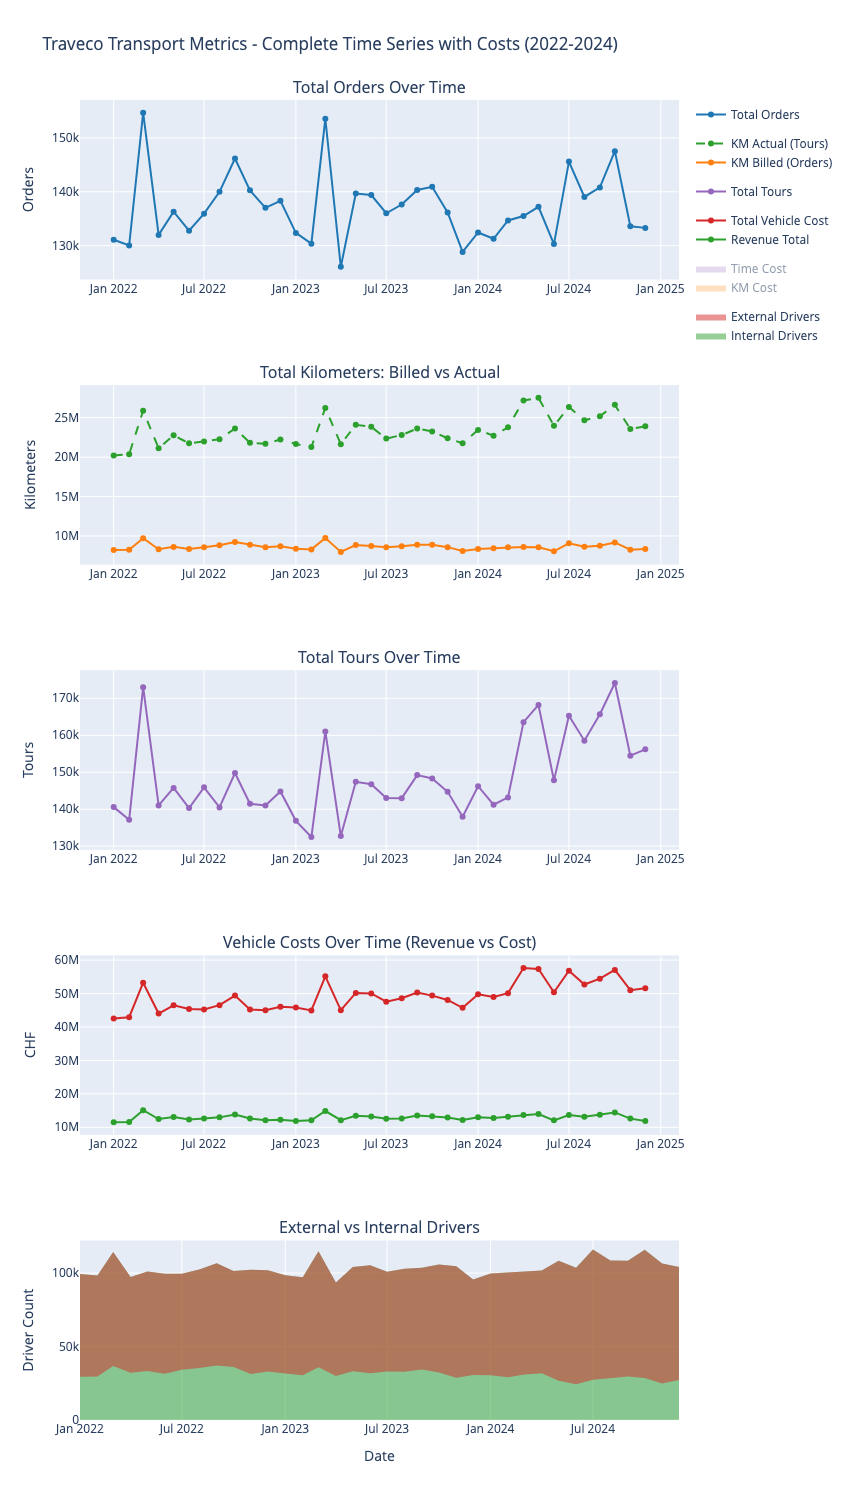


✓ Saved interactive chart to results/time_series_overview.html

KM EFFICIENCY ANALYSIS (Actual / Billed)
  Mean efficiency: 270.21%
  Median efficiency: 266.38%
  Min efficiency: 245.88%
  Max efficiency: 321.01%

  Interpretation:
    < 100%: More efficient (actual < billed)
    = 100%: Perfect match
    > 100%: Less efficient (actual > billed)

  Efficiency Distribution:
    Excellent (<90%): 0 months
    Good (90-100%): 0 months
    Acceptable (100-110%): 0 months
    Poor (>110%): 36 months

FINANCIAL SUMMARY (2022-2024)
  Total Revenue: CHF 464,948,654.81
  Total Vehicle Cost: CHF 1,770,402,814.16
  Total Profit: CHF -1,305,454,159.35
  Average Profit Margin: -280.77%

  Cost Breakdown:
    KM-based cost: CHF 769,278,619.16 (43.5%)
    Time-based cost: CHF 1,001,124,195.01 (56.5%)


In [11]:
# Create multi-panel time series dashboard - UPDATED with 5 panels including costs
fig = make_subplots(
    rows=5, cols=1,
    subplot_titles=(
        'Total Orders Over Time',
        'Total Kilometers: Billed vs Actual',
        'Total Tours Over Time',
        'Vehicle Costs Over Time (Revenue vs Cost)',
        'External vs Internal Drivers'
    ),
    vertical_spacing=0.08
)

# 1. Total Orders
fig.add_trace(
    go.Scatter(
        x=company_ts['date'],
        y=company_ts['total_orders'],
        mode='lines+markers',
        name='Total Orders',
        line=dict(color='#1f77b4', width=2)
    ),
    row=1, col=1
)

# 2. Total KM - Billed vs Actual
if 'total_km_billed' in company_ts.columns:
    fig.add_trace(
        go.Scatter(
            x=company_ts['date'],
            y=company_ts['total_km_billed'],
            mode='lines+markers',
            name='KM Billed (Orders)',
            line=dict(color='#ff7f0e', width=2),
            legendgroup='km'
        ),
        row=2, col=1
    )

if 'total_km_actual' in company_ts.columns:
    fig.add_trace(
        go.Scatter(
            x=company_ts['date'],
            y=company_ts['total_km_actual'],
            mode='lines+markers',
            name='KM Actual (Tours)',
            line=dict(color='#2ca02c', width=2, dash='dash'),
            legendgroup='km'
        ),
        row=2, col=1
    )

# Fallback if only total_km exists
if 'total_km_billed' not in company_ts.columns and 'total_km' in company_ts.columns:
    fig.add_trace(
        go.Scatter(
            x=company_ts['date'],
            y=company_ts['total_km'],
            mode='lines+markers',
            name='Total KM',
            line=dict(color='#ff7f0e', width=2)
        ),
        row=2, col=1
    )

# 3. Total Tours
if 'total_tours' in company_ts.columns:
    fig.add_trace(
        go.Scatter(
            x=company_ts['date'],
            y=company_ts['total_tours'],
            mode='lines+markers',
            name='Total Tours',
            line=dict(color='#9467bd', width=2)
        ),
        row=3, col=1
    )

# 4. Vehicle Costs (NEW - Revenue vs Cost comparison)
if 'revenue_total' in company_ts.columns:
    fig.add_trace(
        go.Scatter(
            x=company_ts['date'],
            y=company_ts['revenue_total'],
            mode='lines+markers',
            name='Revenue Total',
            line=dict(color='#2ca02c', width=2),
            legendgroup='finance'
        ),
        row=4, col=1
    )

if 'total_vehicle_cost' in company_ts.columns:
    fig.add_trace(
        go.Scatter(
            x=company_ts['date'],
            y=company_ts['total_vehicle_cost'],
            mode='lines+markers',
            name='Total Vehicle Cost',
            line=dict(color='#d62728', width=2),
            legendgroup='finance'
        ),
        row=4, col=1
    )
    
    # Add cost breakdown (stacked area for KM and Time costs)
    if 'vehicle_km_cost' in company_ts.columns and 'vehicle_time_cost' in company_ts.columns:
        fig.add_trace(
            go.Scatter(
                x=company_ts['date'],
                y=company_ts['vehicle_km_cost'],
                mode='lines',
                name='KM Cost',
                line=dict(color='#ff7f0e', width=0),
                fill='tozeroy',
                legendgroup='cost_breakdown',
                visible='legendonly'  # Hidden by default
            ),
            row=4, col=1
        )
        
        fig.add_trace(
            go.Scatter(
                x=company_ts['date'],
                y=company_ts['vehicle_time_cost'],
                mode='lines',
                name='Time Cost',
                line=dict(color='#9467bd', width=0),
                fill='tonexty',
                legendgroup='cost_breakdown',
                visible='legendonly'  # Hidden by default
            ),
            row=4, col=1
        )

# 5. Drivers (stacked)
fig.add_trace(
    go.Scatter(
        x=company_ts['date'],
        y=company_ts['internal_drivers'],
        mode='lines',
        name='Internal Drivers',
        line=dict(color='#2ca02c', width=0),
        fill='tozeroy',
        legendgroup='drivers'
    ),
    row=5, col=1
)

fig.add_trace(
    go.Scatter(
        x=company_ts['date'],
        y=company_ts['external_drivers'],
        mode='lines',
        name='External Drivers',
        line=dict(color='#d62728', width=0),
        fill='tonexty',
        legendgroup='drivers'
    ),
    row=5, col=1
)

# Update layout
fig.update_xaxes(title_text="Date", row=5, col=1)
fig.update_yaxes(title_text="Orders", row=1, col=1)
fig.update_yaxes(title_text="Kilometers", row=2, col=1)
fig.update_yaxes(title_text="Tours", row=3, col=1)
fig.update_yaxes(title_text="CHF", row=4, col=1)
fig.update_yaxes(title_text="Driver Count", row=5, col=1)

fig.update_layout(
    height=1500,  # Increased from 1200 to accommodate 5 panels
    title_text="Traveco Transport Metrics - Complete Time Series with Costs (2022-2024)",
    showlegend=True,
    hovermode='x unified'
)

fig.show()

# Save to results
results_dir = Path('../results')
results_dir.mkdir(exist_ok=True)
fig.write_html(results_dir / 'time_series_overview.html')
print(f"\n✓ Saved interactive chart to results/time_series_overview.html")

# Print KM efficiency summary if available
if 'km_efficiency' in company_ts.columns:
    print(f"\n{'='*80}")
    print(f"KM EFFICIENCY ANALYSIS (Actual / Billed)")
    print(f"{'='*80}")
    efficiency_stats = company_ts['km_efficiency'].describe()
    print(f"  Mean efficiency: {efficiency_stats['mean']:.2%}")
    print(f"  Median efficiency: {efficiency_stats['50%']:.2%}")
    print(f"  Min efficiency: {efficiency_stats['min']:.2%}")
    print(f"  Max efficiency: {efficiency_stats['max']:.2%}")
    print(f"\n  Interpretation:")
    print(f"    < 100%: More efficient (actual < billed)")
    print(f"    = 100%: Perfect match")
    print(f"    > 100%: Less efficient (actual > billed)")
    
    # Count efficiency categories
    excellent = (company_ts['km_efficiency'] < 0.9).sum()
    good = ((company_ts['km_efficiency'] >= 0.9) & (company_ts['km_efficiency'] < 1.0)).sum()
    acceptable = ((company_ts['km_efficiency'] >= 1.0) & (company_ts['km_efficiency'] < 1.1)).sum()
    poor = (company_ts['km_efficiency'] >= 1.1).sum()
    
    print(f"\n  Efficiency Distribution:")
    print(f"    Excellent (<90%): {excellent} months")
    print(f"    Good (90-100%): {good} months")
    print(f"    Acceptable (100-110%): {acceptable} months")
    print(f"    Poor (>110%): {poor} months")

# Print cost summary if available
if 'total_vehicle_cost' in company_ts.columns and 'revenue_total' in company_ts.columns:
    print(f"\n{'='*80}")
    print(f"FINANCIAL SUMMARY (2022-2024)")
    print(f"{'='*80}")
    total_revenue = company_ts['revenue_total'].sum()
    total_cost = company_ts['total_vehicle_cost'].sum()
    total_profit = total_revenue - total_cost
    avg_margin = (total_profit / total_revenue) * 100
    
    print(f"  Total Revenue: CHF {total_revenue:,.2f}")
    print(f"  Total Vehicle Cost: CHF {total_cost:,.2f}")
    print(f"  Total Profit: CHF {total_profit:,.2f}")
    print(f"  Average Profit Margin: {avg_margin:.2f}%")
    
    if 'vehicle_km_cost' in company_ts.columns and 'vehicle_time_cost' in company_ts.columns:
        km_cost_total = company_ts['vehicle_km_cost'].sum()
        time_cost_total = company_ts['vehicle_time_cost'].sum()
        km_pct = (km_cost_total / total_cost) * 100
        time_pct = (time_cost_total / total_cost) * 100
        
        print(f"\n  Cost Breakdown:")
        print(f"    KM-based cost: CHF {km_cost_total:,.2f} ({km_pct:.1f}%)")
        print(f"    Time-based cost: CHF {time_cost_total:,.2f} ({time_pct:.1f}%)")


## Section 8: Seasonality Analysis

Identify seasonal patterns in the data.

In [12]:
# Extract month from date
company_ts['month'] = company_ts['date'].dt.month
company_ts['year'] = company_ts['date'].dt.year

# Calculate monthly averages
monthly_avg = company_ts.groupby('month').agg({
    'total_orders': 'mean',
    'total_km_billed': 'mean',
    'total_drivers': 'mean'
}).reset_index()

# Month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_avg['month_name'] = monthly_avg['month'].apply(lambda x: month_names[x-1])

# Create seasonality chart
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=monthly_avg['month_name'],
        y=monthly_avg['total_orders'],
        name='Avg Orders',
        marker_color='#1f77b4'
    )
)

fig.update_layout(
    title="Seasonal Pattern - Average Orders by Month (2022-2025)",
    xaxis_title="Month",
    yaxis_title="Average Monthly Orders",
    height=500
)

fig.show()

# Identify peak and low months
peak_month = monthly_avg.loc[monthly_avg['total_orders'].idxmax(), 'month_name']
low_month = monthly_avg.loc[monthly_avg['total_orders'].idxmin(), 'month_name']

print(f"\nSeasonality Insights:")
print(f"  Peak month: {peak_month} ({monthly_avg['total_orders'].max():.0f} orders)")
print(f"  Low month: {low_month} ({monthly_avg['total_orders'].min():.0f} orders)")
print(f"  Seasonal variation: {(monthly_avg['total_orders'].max() / monthly_avg['total_orders'].min() - 1) * 100:.1f}%")


Seasonality Insights:
  Peak month: Mar (147638 orders)
  Low month: Feb (130556 orders)
  Seasonal variation: 13.1%


## Section 9: Save Final Datasets

Save both Betriebszentralen-level and company-level time series.

In [13]:
output_dir = Path('../data/processed')

# 1. Save Betriebszentralen-level time series
bz_output = output_dir / 'monthly_aggregated_full_bz.csv'
print(f"Saving Betriebszentralen-level time series to {bz_output}...")
df_full_ts.to_csv(bz_output, index=False)
print(f"✓ Saved {len(df_full_ts):,} records")

# 2. Save company-level time series
company_output = output_dir / 'monthly_aggregated_full_company.csv'
print(f"\nSaving company-level time series to {company_output}...")
company_ts.to_csv(company_output, index=False)
print(f"✓ Saved {len(company_ts)} months")

# 3. Save as Parquet for faster loading in forecasting notebooks
company_ts.to_parquet(output_dir / 'monthly_aggregated_full_company.parquet', index=False)
print(f"✓ Saved Parquet version")

print(f"\n{'='*80}")
print(f"TIME SERIES AGGREGATION COMPLETE!")
print(f"{'='*80}")
print(f"\nDatasets ready for forecasting:")
print(f"  1. Betriebszentralen-level: {len(df_full_ts):,} month-entity records")
print(f"  2. Company-level: {len(company_ts)} monthly records")
print(f"  3. Time range: {company_ts['date'].min()} to {company_ts['date'].max()}")
print(f"  4. Total months: {len(company_ts)}")
print(f"\nNext step: Proceed to forecasting notebooks (09-15)")

Saving Betriebszentralen-level time series to ../data/processed/monthly_aggregated_full_bz.csv...
✓ Saved 369 records

Saving company-level time series to ../data/processed/monthly_aggregated_full_company.csv...
✓ Saved 36 months
✓ Saved Parquet version

TIME SERIES AGGREGATION COMPLETE!

Datasets ready for forecasting:
  1. Betriebszentralen-level: 369 month-entity records
  2. Company-level: 36 monthly records
  3. Time range: 2022-01-01 00:00:00 to 2024-12-01 00:00:00
  4. Total months: 36

Next step: Proceed to forecasting notebooks (09-15)


## Section 10: Summary Statistics

Final overview of the complete time series.

In [14]:
print("Complete Time Series Summary")
print("="*80)

print(f"\n1. Coverage:")
print(f"   Start date: {company_ts['date'].min()}")
print(f"   End date: {company_ts['date'].max()}")
print(f"   Total months: {len(company_ts)}")
print(f"   Years covered: {sorted(company_ts['year'].unique())}")

print(f"\n2. Totals (across all months):")
print(f"   Total orders: {company_ts['total_orders'].sum():,.0f}")
print(f"   Total KM: {company_ts['total_km_billed'].sum():,.0f}")
print(f"   Avg KM/order: {(company_ts['total_km_billed'].sum() / company_ts['total_orders'].sum()):.1f}")

print(f"\n3. Monthly Averages:")
print(f"   Avg orders/month: {company_ts['total_orders'].mean():,.0f}")
print(f"   Avg KM/month: {company_ts['total_km_billed'].mean():,.0f}")
print(f"   Avg drivers/month: {company_ts['total_drivers'].mean():.0f}")

print(f"\n4. Betriebszentralen:")
print(f"   Total entities: {df_full_ts['betriebszentrale'].nunique()}")
print(f"   List: {sorted(df_full_ts['betriebszentrale'].unique())}")

print(f"\n5. Data Quality:")
print(f"   Missing values: {company_ts.isna().sum().sum()}")
print(f"   Duplicate months: {company_ts['year_month'].duplicated().sum()}")

print(f"\n✓ Dataset is ready for time series forecasting!")

Complete Time Series Summary

1. Coverage:
   Start date: 2022-01-01 00:00:00
   End date: 2024-12-01 00:00:00
   Total months: 36
   Years covered: [np.int32(2022), np.int32(2023), np.int32(2024)]

2. Totals (across all months):
   Total orders: 4,937,090
   Total KM: 310,761,047
   Avg KM/order: 62.9

3. Monthly Averages:
   Avg orders/month: 137,141
   Avg KM/month: 8,632,251
   Avg drivers/month: 134727

4. Betriebszentralen:
   Total entities: 11
   List: ['B&T Landquart', 'B&T Puidoux', 'B&T Winterthur', 'BZ Herzogenbuchsee', 'BZ Intermodal / Rail', 'BZ Landquart', 'BZ Oberbipp', 'BZ Puidoux', 'BZ Sierre', 'BZ Sursee', 'BZ Winterthur']

5. Data Quality:
   Missing values: 0
   Duplicate months: 0

✓ Dataset is ready for time series forecasting!
